# June 3, 2024: measure(s) of variations of community labels of rois

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations, product


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import colorcet as cc

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240605-16:55:53,551 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group')
PNG_path = f'{ROI_RESULTS_path}/png'
os.system(f'mkdir -p {PNG_path}/group')

# # sbm model class
# args.dc = 'nd'
# args.sbm = 'd' 

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
models_list = [
    ('', 'a'),
    ('dc', 'd'),
    ('nd', 'd'),
    ('dc', 'h'),
    ('nd', 'h'),
]

In [10]:
def plot(args, SBM, mode_df):
    ncols = 3
    nrows = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 4*nrows), dpi=90, sharex=False, sharey=False)
    fig.tight_layout(h_pad=3, w_pad=2.5)

    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    cmap = cc.cm.CET_L12
    ylabels = ['probability, $\omega_k$', 'uncertainty, $\sigma_k$', 'ratio, $\omega_k$ / $\sigma_k$']
    for idx, col in enumerate(mode_df.columns[2:5]):
        ax = axs[idx]
        ax.bar(x=mode_df.index.to_list(), height=mode_df[col].to_list(), color=cmap(rescale(mode_df[col])), width=0.95)
        # sns.barplot(data=mode_df, x=mode_df.index, y=col, ax=ax,) # palette='Blues_r')
        # sns.barplot(data=mode_df, x=mode_df.index, y=col, ax=ax, palette=cmap(rescale(mode_df[col]))) 
        ax.set(ylabel=ylabels[idx], xlabel='mode $k$')
        if idx == 1: ax.set(title=f'{SBM} mode summary')

    plt.savefig(f'{PNG_path}/group/{SBM}_desc-summary.png', bbox_inches='tight')
    return None

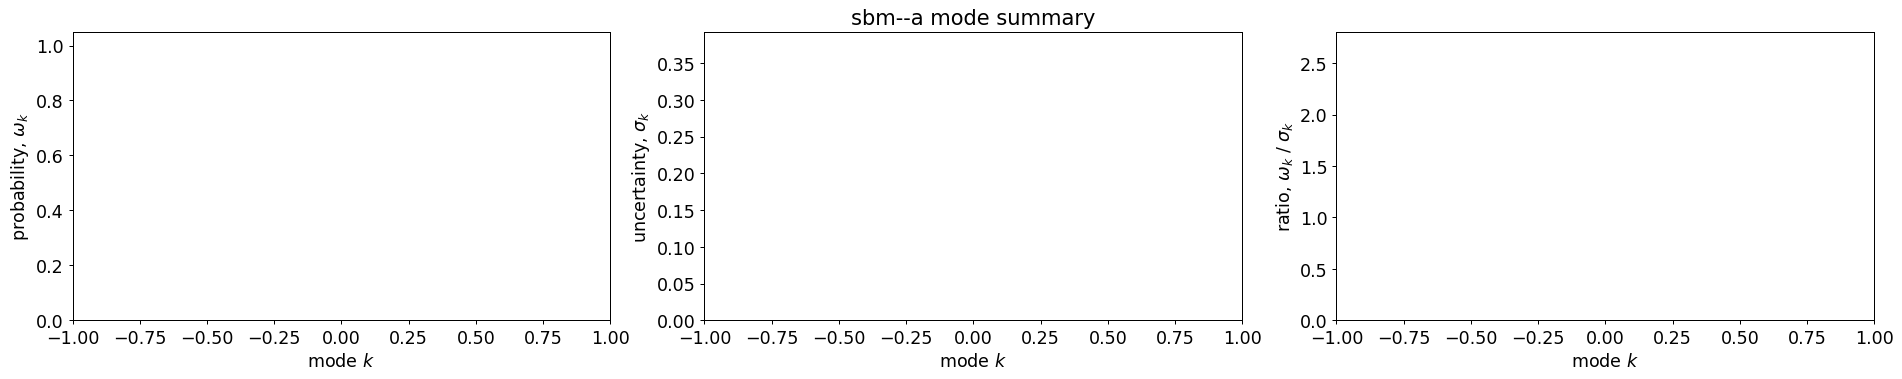

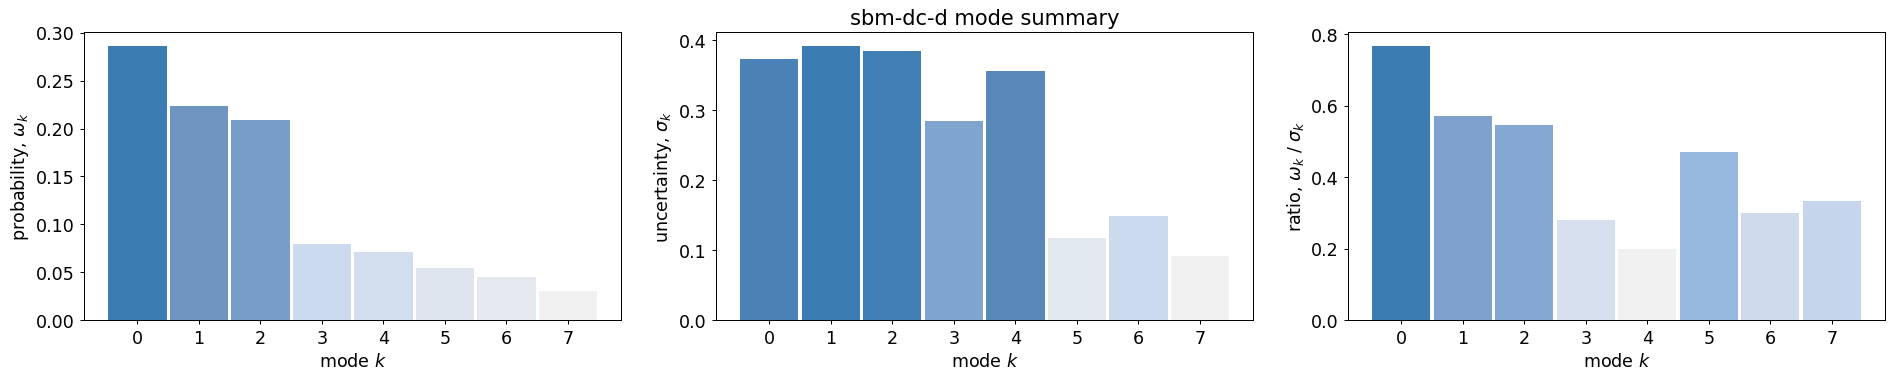

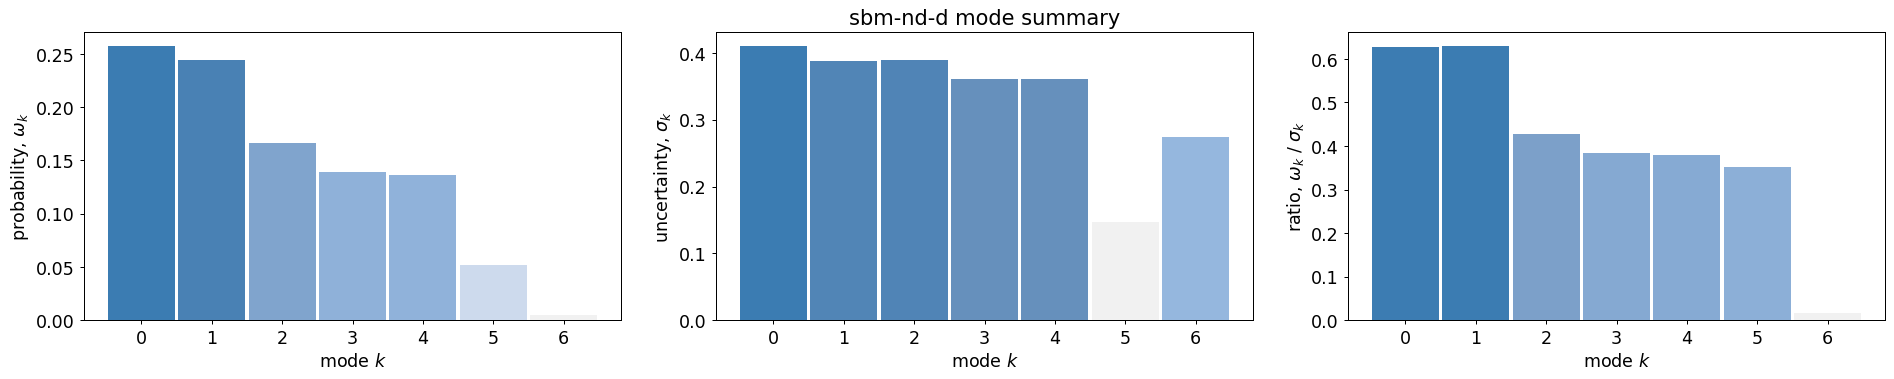

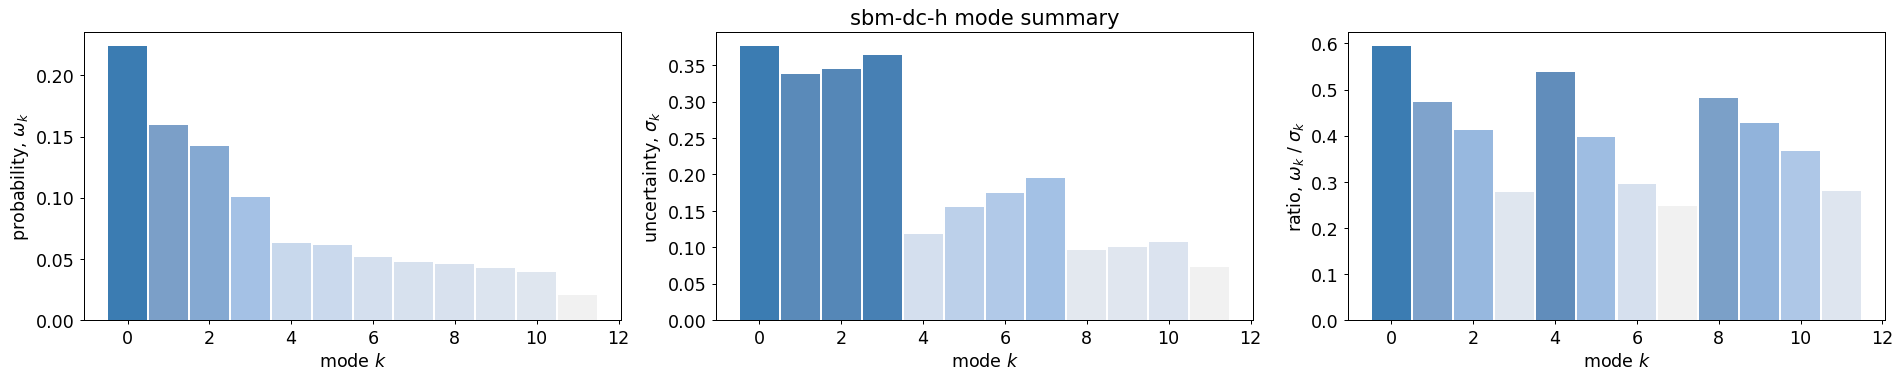

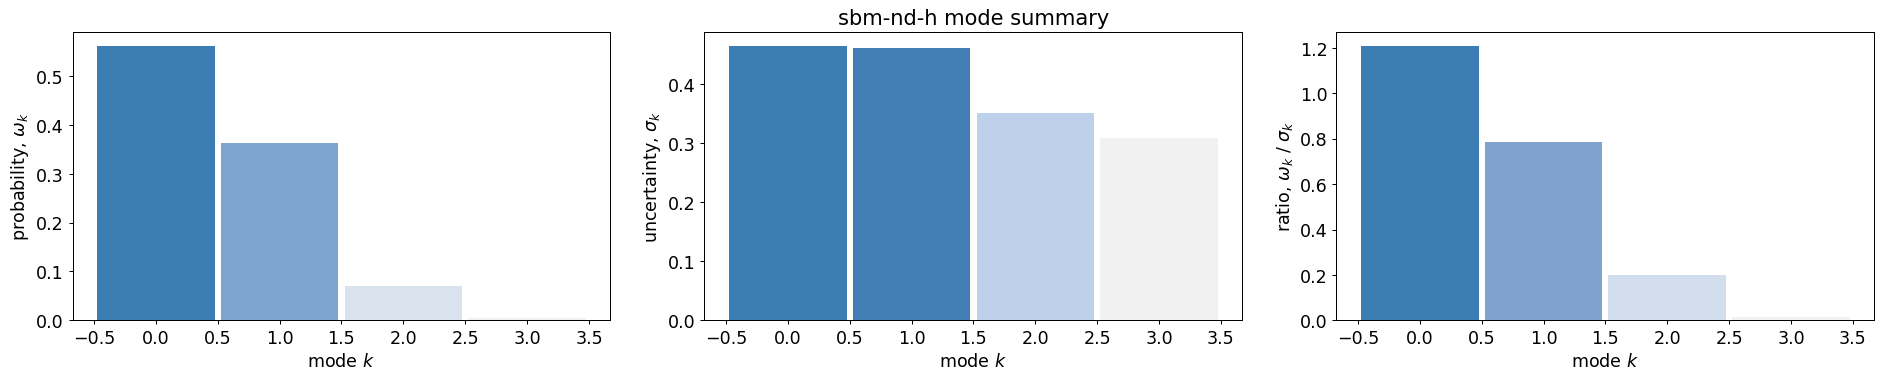

In [11]:
for model in models_list:
    args.dc, args.sbm = model
    SBM = f'sbm-{args.dc}-{args.sbm}'
    with open(f'{NPY_path}/{SBM}_desc-group-modes.npy', 'rb') as f:
        [dfs, mode_df] = pickle.load(f)
    plot(args, SBM, mode_df)
    # break